--- 1. Data Fetching ---
--- 2. Environment Setup ---
--- 3. Training Agent (150000 steps) ---
Using mps device


/var/folders/04/4l6xjjw976j6gj89kg1qrrf80000gn/T/ipykernel_34685/2552770827.py:66: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(self.tickers, start=self.start_date, end=self.end_date, progress=False)
/opt/anaconda3/envs/ml/lib/python3.11/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


-----------------------------
| time/              |      |
|    fps             | 127  |
|    iterations      | 1    |
|    time_elapsed    | 16   |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 2            |
|    time_elapsed         | 43           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0009274702 |
|    clip_fraction        | 0.00249      |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.41        |
|    explained_variance   | -0.00344     |
|    learning_rate        | 0.0003       |
|    loss                 | 4.71         |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.000658    |
|    std                  | 0.992        |
|    value_loss           | 14           |
----------------

/var/folders/04/4l6xjjw976j6gj89kg1qrrf80000gn/T/ipykernel_34685/2552770827.py:66: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(self.tickers, start=self.start_date, end=self.end_date, progress=False)



FINAL PERFORMANCE REPORT (SPY)
Metric               | Strategy     | Benchmark   
--------------------------------------------------
Total Return         |      16.77% |      17.68%
Sharpe Ratio         |        1.57 |        1.59
Max Drawdown         |      -6.07% |      -8.41%
Win Rate             |      55.92% |         N/A
Total Trades         |          38 |         N/A
Avg Exposure         |        0.84 |        1.00
--------------------------------------------------
Initial Balance: $100,000.00
Final Balance:   $116,769.51


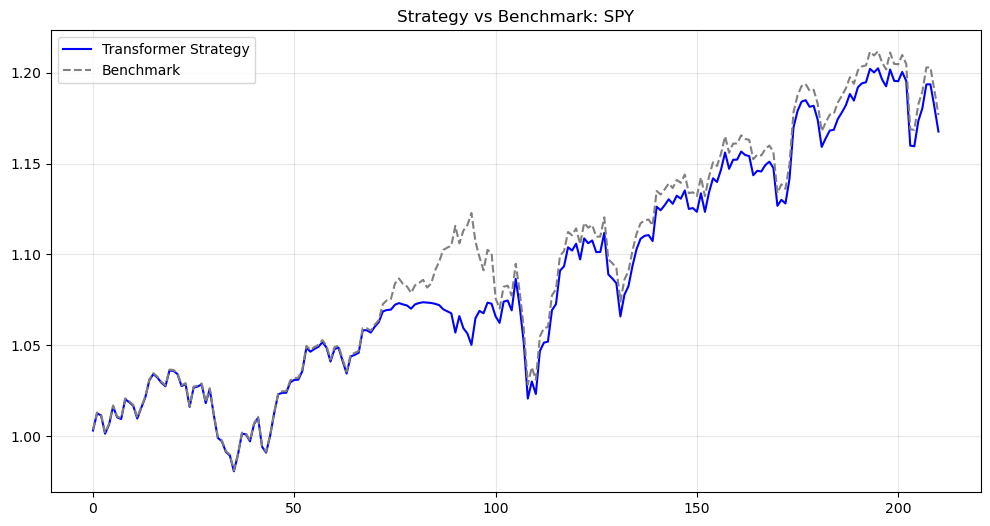

In [6]:
import yfinance as yf
import pandas as pd
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import torch
import torch.nn as nn
from stable_baselines3 import PPO
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
import matplotlib.pyplot as plt
import sys

# ==========================================
# 1. HYPERPARAMETERS & CONFIGURATION
# ==========================================
CONFIG = {
    # Data Settings
    "TICKERS": ["SPY", "QQQ", "GLD", "^VIX"],
    "TARGET_ASSET": "SPY",
    "START_DATE": "2015-01-01",
    "END_DATE": "2023-12-31",
    "TEST_START_DATE": "2024-01-02",
    
    # Feature Engineering
    "WINDOW_SIZE": 20,
    "TECHNICAL_INDICATORS": True,
    
    # RL Environment Settings
    "INITIAL_BALANCE": 100000,
    "TRADING_FEES": 0.0005,  # 5 bps
    
    # Reward Shaping: ALPHA GENERATION
    # R = (Strategy_Return - Benchmark_Return) - Risk
    # This forces the agent to beat the market, not just join it.
    "REWARD_METHOD": "excess_return", 
    "RISK_AVERSION": 0.5,  
    "REWARD_SCALING": 100.0,
    
    # Transformer Architecture
    "D_MODEL": 64,
    "N_HEAD": 4,
    "N_LAYERS": 2,
    "DROPOUT": 0.1,
    
    # PPO Agent Settings
    "LEARNING_RATE": 3e-4,
    "N_STEPS": 2048,
    "BATCH_SIZE": 64,
    "ENTROPY_COEF": 0.02, # Slightly higher to encourage finding unique strategies
    "TRAINING_TIMESTEPS": 150000
}

# ==========================================
# 2. ROBUST DATA PIPELINE
# ==========================================
class DataProcessor:
    def __init__(self, tickers, start_date, end_date):
        self.tickers = tickers
        self.start_date = start_date
        self.end_date = end_date
        
    def download_data(self):
        print(f"Downloading data for {self.tickers}...")
        try:
            data = yf.download(self.tickers, start=self.start_date, end=self.end_date, progress=False)
            if data.empty: return pd.DataFrame()

            if isinstance(data.columns, pd.MultiIndex):
                if 'Close' in data.columns.levels[0]:
                    data = data.xs('Close', level=0, axis=1)
                elif 'Adj Close' in data.columns.levels[0]:
                    data = data.xs('Adj Close', level=0, axis=1)
                elif 'Close' in data.columns.levels[1]:
                    data = data.xs('Close', level=1, axis=1)
            
            if isinstance(data, pd.Series): data = data.to_frame()
            return data
        except Exception as e:
            print(f"Error during download: {e}")
            return pd.DataFrame()

    def add_technical_indicators(self, df, target_ticker):
        if df.empty or target_ticker not in df.columns: return pd.DataFrame()
        df = df.copy()
        
        # Returns
        df['returns'] = df[target_ticker].pct_change()
        
        # RSI
        delta = df[target_ticker].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / loss
        df['rsi'] = 100 - (100 / (1 + rs))
        
        # MACD
        exp1 = df[target_ticker].ewm(span=12, adjust=False).mean()
        exp2 = df[target_ticker].ewm(span=26, adjust=False).mean()
        df['macd'] = exp1 - exp2
        
        # Rolling Volatility
        df['volatility'] = df['returns'].rolling(window=20).std()
        
        # Z-Score
        window = 20
        rolling_mean = df[target_ticker].rolling(window=window).mean()
        rolling_std = df[target_ticker].rolling(window=window).std()
        df['z_score'] = (df[target_ticker] - rolling_mean) / (rolling_std + 1e-8)
        
        df.dropna(inplace=True)
        return df

    def get_processed_data(self, target_ticker):
        df = self.download_data()
        if df.empty: return pd.DataFrame()
        df = self.add_technical_indicators(df, target_ticker)
        if df.empty: return pd.DataFrame()
        
        features = ['returns', 'z_score', 'rsi', 'macd', 'volatility']
        if '^VIX' in df.columns:
            df['vix_norm'] = (df['^VIX'] - df['^VIX'].rolling(50).mean()) / (df['^VIX'].rolling(50).std() + 1e-8)
            df['vix_norm'] = df['vix_norm'].fillna(0)
            features.append('vix_norm')
            
        return df[features].fillna(0)

# ==========================================
# 3. TRADING ENVIRONMENT
# ==========================================
class TransformerTradingEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, df, config):
        super(TransformerTradingEnv, self).__init__()
        self.df = df
        self.config = config
        self.window_size = config['WINDOW_SIZE']
        self.n_features = df.shape[1]
        
        self.action_space = spaces.Box(low=-1, high=1, shape=(1,), dtype=np.float32)
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, 
            shape=(self.window_size, self.n_features), 
            dtype=np.float32
        )
        
        self.current_step = self.window_size
        self.balance = config['INITIAL_BALANCE']
        self.portfolio_value = self.balance
        self.history = []

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = self.window_size
        self.balance = self.config['INITIAL_BALANCE']
        self.portfolio_value = self.balance
        self.history = []
        return self._get_observation(), {}

    def _get_observation(self):
        obs = self.df.iloc[self.current_step - self.window_size : self.current_step].values
        return obs.astype(np.float32)

    def step(self, action):
        action = np.clip(action, -1, 1)[0]
        
        if self.current_step >= len(self.df):
            return self._get_observation(), 0, True, False, {}
            
        market_return = self.df.iloc[self.current_step]['returns']
        
        # Transaction Costs
        prev_action = self.history[-1]['action'] if len(self.history) > 0 else 0
        turnover = abs(action - prev_action)
        cost = turnover * self.config['TRADING_FEES']
        
        # Return Calculation
        strategy_return = (action * market_return) - cost
        self.portfolio_value *= (1 + strategy_return)
        
        # --- REWARD ENGINEERING: ALPHA SEEKING ---
        # Reward = (Strategy Return - Benchmark Return) - Risk Penalty
        # This penalizes "Closet Indexing" (where strat_ret ~= bench_ret) because of costs/risk.
        excess_return = strategy_return - market_return
        risk_penalty = 0.5 * self.config['RISK_AVERSION'] * (strategy_return ** 2)
        
        # If Reward Method is Excess Return, use Alpha. Otherwise default.
        if self.config['REWARD_METHOD'] == 'excess_return':
            reward = (excess_return - risk_penalty) * self.config['REWARD_SCALING']
        else:
            reward = (strategy_return - risk_penalty) * self.config['REWARD_SCALING']
        
        self.current_step += 1
        terminated = self.current_step >= len(self.df) - 1
        
        info = {
            'portfolio_value': self.portfolio_value,
            'return': strategy_return,
            'market_return': market_return,
            'action': action,
            'turnover': turnover
        }
        self.history.append(info)
        
        return self._get_observation(), reward, terminated, False, info

# ==========================================
# 4. TRANSFORMER MODEL
# ==========================================
class TransformerExtractor(BaseFeaturesExtractor):
    def __init__(self, observation_space: spaces.Box, features_dim: int = 64):
        super().__init__(observation_space, features_dim)
        n_input_features = observation_space.shape[1]
        self.window_size = observation_space.shape[0]
        
        self.embedding = nn.Linear(n_input_features, CONFIG['D_MODEL'])
        self.position_embedding = nn.Parameter(torch.randn(1, self.window_size, CONFIG['D_MODEL']))
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=CONFIG['D_MODEL'],
            nhead=CONFIG['N_HEAD'],
            dim_feedforward=128,
            dropout=CONFIG['DROPOUT'],
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=CONFIG['N_LAYERS'])
        
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(CONFIG['D_MODEL'] * self.window_size, features_dim)
        self.activation = nn.ReLU()

    def forward(self, observations):
        x = self.embedding(observations) + self.position_embedding
        x = self.transformer_encoder(x)
        x = self.flatten(x)
        return self.activation(self.linear(x))

# ==========================================
# 5. EXECUTION & ANALYSIS
# ==========================================
def calculate_metrics(returns):
    if len(returns) < 2: return 0, 0
    sharpe = (np.mean(returns) / (np.std(returns) + 1e-9)) * np.sqrt(252)
    cum_returns = (1 + returns).cumprod()
    peak = np.maximum.accumulate(cum_returns)
    drawdown = (cum_returns - peak) / peak
    return sharpe, drawdown.min()

def run_strategy():
    print("--- 1. Data Fetching ---")
    data_loader = DataProcessor(CONFIG['TICKERS'], CONFIG['START_DATE'], CONFIG['END_DATE'])
    train_df = data_loader.get_processed_data(CONFIG['TARGET_ASSET'])
    
    if train_df.empty: return

    print("--- 2. Environment Setup ---")
    # For Alpha strategies, we often turn OFF reward normalization to let the agent 
    # feel the exact magnitude of beating/missing the market.
    env = DummyVecEnv([lambda: TransformerTradingEnv(train_df, CONFIG)])
    env = VecNormalize(env, norm_obs=True, norm_reward=False, clip_obs=10.)
    
    print(f"--- 3. Training Agent ({CONFIG['TRAINING_TIMESTEPS']} steps) ---")
    policy_kwargs = dict(features_extractor_class=TransformerExtractor, features_extractor_kwargs=dict(features_dim=64))
    
    model = PPO("MlpPolicy", env, policy_kwargs=policy_kwargs, learning_rate=CONFIG['LEARNING_RATE'], ent_coef=CONFIG['ENTROPY_COEF'], verbose=1, device='mps')
    model.learn(total_timesteps=CONFIG['TRAINING_TIMESTEPS'])
    
    print("--- 4. Backtesting & Analysis ---")
    test_loader = DataProcessor(CONFIG['TICKERS'], CONFIG['TEST_START_DATE'], "2025-01-01")
    test_df = test_loader.get_processed_data(CONFIG['TARGET_ASSET'])
    
    if test_df.empty or len(test_df) <= CONFIG['WINDOW_SIZE']: return

    test_env = DummyVecEnv([lambda: TransformerTradingEnv(test_df, CONFIG)])
    test_env = VecNormalize(test_env, norm_obs=True, norm_reward=False, clip_obs=10.)
    test_env.obs_rms = env.obs_rms
    test_env.training = False

    obs = test_env.reset()
    strategy_history = []
    
    while True:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done_array, info_array = test_env.step(action)
        strategy_history.append(info_array[0])
        if done_array[0]: break
        
    # --- Performance Analysis ---
    results_df = pd.DataFrame(strategy_history)
    
    strat_ret = results_df['return']
    bench_ret = results_df['market_return']
    
    strat_total = (results_df['portfolio_value'].iloc[-1] / CONFIG['INITIAL_BALANCE']) - 1
    bench_total = (1 + bench_ret).cumprod().iloc[-1] - 1
    
    strat_sharpe, strat_mdd = calculate_metrics(strat_ret)
    bench_sharpe, bench_mdd = calculate_metrics(bench_ret)
    
    # Advanced Stats
    win_rate = (strat_ret > 0).mean()
    total_trades = (results_df['turnover'] > 0.01).sum() 
    avg_exposure = results_df['action'].mean() # NEW: Check for Bias
    
    print("\n" + "="*50)
    print(f"FINAL PERFORMANCE REPORT ({CONFIG['TARGET_ASSET']})")
    print("="*50)
    print(f"{'Metric':<20} | {'Strategy':<12} | {'Benchmark':<12}")
    print("-" * 50)
    print(f"{'Total Return':<20} | {strat_total:>11.2%} | {bench_total:>11.2%}")
    print(f"{'Sharpe Ratio':<20} | {strat_sharpe:>11.2f} | {bench_sharpe:>11.2f}")
    print(f"{'Max Drawdown':<20} | {strat_mdd:>11.2%} | {bench_mdd:>11.2%}")
    print(f"{'Win Rate':<20} | {win_rate:>11.2%} | {'N/A':>11}")
    print(f"{'Total Trades':<20} | {total_trades:>11} | {'N/A':>11}")
    print(f"{'Avg Exposure':<20} | {avg_exposure:>11.2f} | {'1.00':>11}")
    print("-" * 50)
    print(f"Initial Balance: ${CONFIG['INITIAL_BALANCE']:,.2f}")
    print(f"Final Balance:   ${results_df['portfolio_value'].iloc[-1]:,.2f}")
    
    plt.figure(figsize=(12, 6))
    plt.plot((1 + strat_ret).cumprod(), label='Transformer Strategy', color='blue')
    plt.plot((1 + bench_ret).cumprod(), label='Benchmark', color='gray', linestyle='--')
    plt.title(f"Strategy vs Benchmark: {CONFIG['TARGET_ASSET']}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

if __name__ == "__main__":
    torch.set_num_threads(8)
    run_strategy()